<a href="https://colab.research.google.com/github/Hennakk/DSP_LAB/blob/main/train_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
%cd /content/gdrive/MyDrive/project/HELMET_DETECTION/

/content/gdrive/MyDrive/project/HELMET_DETECTION


In [ ]:
! ls

annotations		   requirements.txt
archive.zip		   res10_300x300_ssd_iter_140000.caffemodel
deploy.prototxt.txt	   saved_model.pb
haarcascade_upperbody.xml  test
helmet.h5		   train
images			   Train_XmlFIle.py
Project_Helmet_Dijon.py    webcam_helmet_detect.py


In [ ]:
import xml.etree.ElementTree as ET #FOR READING XML FILES
import os  #FOR PATH BASED OPERATION
import cv2 # FOR IMAGE BASED OPERATION
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from google.colab.patches import cv2_imshow

In [ ]:
DIRECTORY = r"annotations"
DIRECTORY2 = r"images"

In [ ]:
#Defining some functions
def showBox(frame,xmin,ymin,xmax,ymax,Switch):
    if Switch == 'helmet':
        color = (0,255,0)
    else:
        color = (0,0,255)
    cv2.rectangle(frame,(xmin,ymin),(xmax,ymax),color,2)

###############################################
#READING THE DATASET WHICH IS IN .XML FORMAT
# WE WILl CREATE TWO LIST THAT WILL STORE OUR DATASET
HELMET = []
NO_HELMET = []


for xml_file in os.listdir(DIRECTORY):
  path = os.path.join(DIRECTORY,xml_file)

  tree = ET.parse(path)
  root = tree.getroot()

  img_path = os.path.join(DIRECTORY2,str(root.find('filename').text))
  #print(img_path)
  frame = cv2.imread(img_path)
  cv2_imshow(frame)
  
  for member in root.findall('object'):
    Switch  = member.find('name').text
    for i in member.findall('bndbox'):
      xmin = int(i.find('xmin').text) - 20
      ymin = int(i.find('ymin').text) - 20
      xmax = int(i.find('xmax').text) + 20
      ymax = int(i.find('ymax').text) + 20

      if xmin < 0 :
        xmin = int(i.find('xmin').text)
      if ymin < 0 :
        ymin = int(i.find('ymin').text)
      #print(path)

      if Switch == 'helmet':
        temp = frame[ymin:ymax,xmin:xmax]
        if temp.shape[0] != 0 and temp.shape[1] != 0 :
          temp = cv2.resize(temp,(224,224))
          HELMET.append(temp)
          #print('Added 1 image to HELMET LIST')
      else:
        temp = frame[ymin:ymax,xmin:xmax]
        if temp.shape[0] != 0 and temp.shape[1] != 0 :
          temp = cv2.resize(temp,(224,224))
          NO_HELMET.append(temp)
          #print('Added 1 image to NO_HELMET LIST')
        #     showBox(frame,xmin,ymin,xmax,ymax,Switch)
        # cv2.imshow('hi',frame)
        # cv2.waitKey(200)


In [ ]:
for xml_file in os.listdir(DIRECTORY):
  path = os.path.join(DIRECTORY,xml_file)

  tree = ET.parse(path)
  root = tree.getroot()

  img_path = os.path.join(DIRECTORY2,str(root.find('filename').text))
  frame = cv2.imread(img_path)
  print(frame)
  for member in root.findall('object'):

    Switch  = member.find('name').text
    for i in member.findall('bndbox'):
      xmin = int(i.find('xmin').text) - 20
      ymin = int(i.find('ymin').text) - 20
      xmax = int(i.find('xmax').text) + 20
      ymax = int(i.find('ymax').text) + 20

      if xmin < 0 :
        xmin = int(i.find('xmin').text)
      if ymin < 0 :
        ymin = int(i.find('ymin').text)

      if Switch == 'helmet':
        temp = frame[ymin:ymax,xmin:xmax]
        if temp.shape[0] != 0 and temp.shape[1] != 0 :
            temp = cv2.resize(temp,(224,224))
            HELMET.append(temp)
        # print('Added 1 image to HELMET LIST')
      else:
        temp = frame[ymin:ymax,xmin:xmax]
        if temp.shape[0] != 0 and temp.shape[1] != 0 :
          temp = cv2.resize(temp,(224,224))
          NO_HELMET.append(temp)
        # print('Added 1 image to NO_HELMET LIST')
#     showBox(frame,xmin,ymin,xmax,ymax,Switch)
# cv2.imshow('hi',frame)
# cv2.waitKey(200)

In [ ]:
labels = [] #Helmet image will be labeled as 1 and non helmet will be labeled as 0
img_data = []

for i in HELMET:
  j = cv2.cvtColor(i,cv2.COLOR_BGR2RGB)
  j = tensorflow.keras.applications.mobilenet_v2.preprocess_input(j)
  img_data.append(j)
  labels.append(1.)

for i in NO_HELMET:
  j = cv2.cvtColor(i,cv2.COLOR_BGR2RGB)
  j = tensorflow.keras.applications.mobilenet_v2.preprocess_input(j)
  img_data.append(j)
  labels.append(0.)


#converting to numpy array to pass it to the training model
img_data=np.array(img_data) # converting to numpy FORMAT
labels = np.array([labels]).T

#splitting our data into training data and validation data
(trainX, testX, trainY, testY) = train_test_split(img_data, labels,
	test_size=0.20, stratify=labels, random_state=42)

#This allows us to do generate similar images with different attributes

aug = ImageDataGenerator(
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")


In [ ]:

baseModel = MobileNetV2(weights="imagenet", include_top=False,
	input_tensor=tensorflow.keras.layers.Input(shape=(224, 224, 3)))


#importing necessary models and optimizers for model
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(1, activation="sigmoid")(headModel)

9420800/9406464 [==============================] - 0s 0us/step


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/20
131/131 [==============================] - 61s 357ms/step - loss: 0.4666 - accuracy: 0.7905 - val_loss: 0.2949 - val_accuracy: 0.8761
Epoch 2/20
131/131 [==============================] - 46s 351ms/step - loss: 0.3163 - accuracy: 0.8618 - val_loss: 0.2535 - val_accuracy: 0.8885
Epoch 3/20
131/131 [==============================] - 45s 342ms/step - loss: 0.2807 - accuracy: 0.8811 - val_loss: 0.2398 - val_accuracy: 0.8961
Epoch 4/20
131/131 [==============================] - 47s 360ms/step - loss: 0.2842 - accuracy: 0.8835 - val_loss: 0.2263 - val_accuracy: 0.9009
Epoch 5/20
131/131 [==============================] - 45s 340ms/step - loss: 0.2656 - accuracy: 0.8916 - val_loss: 0.2178 - val_accuracy: 0.9028
Epoch 6/20
131/131 [==============================] - 47s 359ms/step - loss: 0.2460 - accuracy: 0.8986 - val_loss: 0.2088 - val_accuracy: 0.9152
Epoch 7/20
131/131 [==============================] - 45s 344ms/step - loss: 0.2405 - accuracy: 0.8976 - val_loss: 0.2080 - val_ac

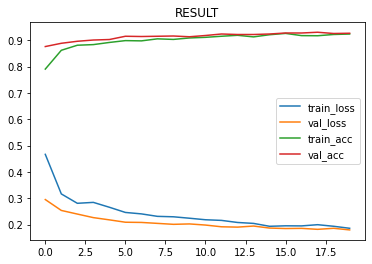

In [ ]:
model = Model(inputs=baseModel.input, outputs=headModel)

for layer in baseModel.layers:
  layer.trainable = False

#Initializing different parameters
learning_rate = 1e-4
epochs = 20
batchsize = 32

opt = Adam(lr=learning_rate, decay= learning_rate / epochs)
model.compile(loss="binary_crossentropy", optimizer=opt,
	metrics=["accuracy"])

history=model.fit(aug.flow(trainX,trainY,batch_size=batchsize),
                    steps_per_epoch=len(trainX)//batchsize,
                    validation_data=(testX,testY),
                    validation_steps=len(testX)//batchsize,
                    epochs=epochs
                   )

import matplotlib.pyplot as plt
plt.figure()
plt.plot(np.arange(0,epochs),history.history["loss"],label="train_loss")
plt.plot(np.arange(0,epochs),history.history["val_loss"],label="val_loss")
plt.plot(np.arange(0,epochs),history.history["accuracy"],label="train_acc")
plt.plot(np.arange(0,epochs),history.history["val_accuracy"],label="val_acc")
plt.title("RESULT")
plt.legend()
plt.show()

model.save("helmet.h5")
cv2.destroyAllWindows()

In [ ]:
score = model.evaluate(testX, testY)
print('Test score:', score[0])
print('Test accuracy:', score[1])

33/33 [==============================] - 2s 59ms/step - loss: 0.1796 - accuracy: 0.9266
Test score: 0.17957265675067902
Test accuracy: 0.9265967607498169
